# UKF

In [1]:
import numpy as np
import scipy
import argparse
import sys
import os
from scipy.integrate import solve_ivp
import time 

def fOde(theta, x):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    global N
    logS = x[:, 0]
    logE = x[:, 1]
    logI = x[:, 2]
    logD = x[:, 3]
    logSdt = -theta[:, 0] * np.exp(logI) / N  # (1)
    logEdt = theta[:, 0] * np.exp(logS + logI - logE) / N - theta[:, 1]  # (2)
    logIdt = np.exp(logE - logI) * theta[:, 1] - theta[:, 2]  # (3)
    logDdt = np.exp(logI - logD) * theta[:, 3] * theta[:, 2] * 0.25  # (4)
    return np.stack([logSdt, logEdt, logIdt, logDdt], axis=1)

# UKF ----

def find_all_sigma_points(x_bar, x_var, alpha=1e-3, kappa=0, beta=2):
    l_dim_x = len(x_bar)
    lambda_scaling = alpha**2 * (l_dim_x + kappa) - l_dim_x
    eigval, eigmat = np.linalg.eig((l_dim_x + lambda_scaling) * x_var)
    matsqrt = eigmat @ np.diag(np.sqrt(eigval)) @ eigmat.transpose()
    sigma_points = np.block([
        [x_bar],
        [x_bar + matsqrt],
        [x_bar - matsqrt]])
    weight_m = np.ones(2*l_dim_x+1) / (2 * (l_dim_x + lambda_scaling))
    weight_m[0] = lambda_scaling / (l_dim_x + lambda_scaling)
    weight_c = np.copy(weight_m)
    weight_c[0] = lambda_scaling / (l_dim_x + lambda_scaling) + (1 - alpha**2 + beta)
    return dict(sigma_points=sigma_points, weight_m=weight_m, weight_c=weight_c)



N = 100000
days = 32
obs_per_day = 1
discretization = 1
time_ls = np.zeros(100)
ukf_ls = np.zeros((100, days * discretization, 16))
for EachRep in range(100):
    start_time = time.time()
    SEED = np.random.randint(1, 100000)
    np.random.seed(SEED)
    yobs = np.load('SEIRD observations.npy')[EachRep]
    ydata = yobs.copy()
    ydata[:, 1] = np.interp(np.arange(0, days, 1), np.arange(0, days, 2), yobs[::2, 1])
    tvecObs = np.arange(0, 32, 1)
    tvecFull = np.arange(0, 32, 1 / discretization)
    yFull = np.ndarray([days * discretization, ydata.shape[1]])
    yFull.fill(np.nan)
    yFull[np.arange(0, days * discretization, discretization).astype(int), :] = ydata
    xInitExogenous = np.zeros_like(yFull)
    for j in range(ydata.shape[1]):
        xInitExogenous[:, j] = np.interp(tvecFull, tvecObs, ydata[:, j])
        
        
    noise = 0.2
    dim_x = 4
    dim_theta = 4
    prior_mean_x_theta_u_e = np.array([yFull[0, 0], yFull[0, 1], yFull[0, 2], yFull[0, 3], 1.8, 0.1, 0.1, 0.2,0,0,0,0,0,0,0,0])
    prior_variance_x_theta = np.diag([noise ** 2, noise ** 2,noise ** 2,noise ** 2, 1, 1, 1, 1])
    variance_u_unit_time = np.diag([0.1, 0.01, 0.001, 0.01])
    prior_variance_e = np.diag([noise ** 2, noise ** 2, noise ** 2, noise ** 2])

    estimate_x_theta_u_e = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta + dim_theta + dim_x])
    variance_x_theta_u_e = np.zeros(shape=[yFull.shape[0], dim_x + dim_theta + dim_theta + dim_x, dim_x + dim_theta + dim_theta + dim_x])

    estimate_x_theta_u_e[0] = prior_mean_x_theta_u_e
    variance_x_theta_u_e[0] = scipy.linalg.block_diag(prior_variance_x_theta, variance_u_unit_time, prior_variance_e)
    for k in range(1, yFull.shape[0]):
        delta_t = tvecFull[k] - tvecFull[k-1]
        variance_x_theta_u_e[k-1][(dim_x + dim_theta):(dim_x + 2 * dim_theta), (dim_x + dim_theta):(dim_x + 2 * dim_theta)] *= delta_t

        unscented_info = find_all_sigma_points(estimate_x_theta_u_e[k-1], variance_x_theta_u_e[k-1])

        sigma_points_pred_theta = unscented_info['sigma_points'][:, dim_x:(dim_x+dim_theta)] + unscented_info['sigma_points'][:, (dim_x+dim_theta):(dim_x+2*dim_theta)]
        sigma_points_previous_x = unscented_info['sigma_points'][:, :dim_x]
        sigma_points_pred_x = sigma_points_previous_x + delta_t * fOde(sigma_points_pred_theta, sigma_points_previous_x)

        mean_pred_x = np.sum(sigma_points_pred_x * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        mean_pred_theta = np.sum(sigma_points_pred_theta * unscented_info['weight_m'].reshape([-1, 1]), axis=0)

        mean_pred_x_theta = np.concatenate([mean_pred_x, mean_pred_theta])
        sigma_points_pred_x_theta = np.block([sigma_points_pred_x, sigma_points_pred_theta])
        var_pred_x_theta = np.zeros([dim_x + dim_theta, dim_x + dim_theta])
        for i in range(sigma_points_pred_x_theta.shape[0]):
            residual = sigma_points_pred_x_theta[i, :] - mean_pred_x_theta
            var_pred_x_theta += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])

        sigma_points_pred_u_e =  unscented_info['sigma_points'][:, (dim_x+dim_theta):]
        mean_pred_u_e = np.sum(sigma_points_pred_u_e * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        var_pred_u_e = np.zeros([dim_x + dim_theta, dim_x + dim_theta])
        for i in range(sigma_points_pred_u_e.shape[0]):
            residual = sigma_points_pred_u_e[i, :] - mean_pred_u_e
            var_pred_u_e += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])
        sigma_points_pred = np.block([sigma_points_pred_x_theta, sigma_points_pred_u_e])
        mean_pred = np.sum(sigma_points_pred * unscented_info['weight_m'].reshape([-1, 1]), axis=0)
        var_pred = np.zeros([2 * (dim_x + dim_theta), 2 * (dim_x + dim_theta)])
        for i in range(sigma_points_pred.shape[0]):
            residual = sigma_points_pred[i, :] - mean_pred
            var_pred += unscented_info['weight_c'][i] * residual.reshape([-1, 1]) @ residual.reshape([1, -1])


        if not np.any(np.isfinite(yFull[k, :])):
            estimate_x_theta_u_e[k] = np.concatenate([mean_pred_x_theta, mean_pred_u_e])
            variance_x_theta_u_e[k] = scipy.linalg.block_diag(var_pred_x_theta, variance_u_unit_time, prior_variance_e)
        else:
            yobs = yFull[k, :]
            sigma_points_pred_y = sigma_points_pred_x + unscented_info['sigma_points'][:, (dim_x + 2 * dim_theta):]
            mean_pred_y = np.sum(sigma_points_pred_y * unscented_info['weight_m'].reshape([-1, 1]), axis=0)

            var_pred_y = np.zeros([dim_x, dim_x])
            cov_pred_xtheta_y = np.zeros([dim_x + dim_theta, dim_x])
            for i in range(sigma_points_pred_y.shape[0]):
                residual_y = sigma_points_pred_y[i, :] - mean_pred_y
                residual_xtheta = sigma_points_pred_x_theta[i, :] - mean_pred_x_theta
                var_pred_y += unscented_info['weight_c'][i] * residual_y.reshape([-1, 1]) @ residual_y.reshape([1, -1])
                cov_pred_xtheta_y += unscented_info['weight_c'][i] * residual_xtheta.reshape([-1, 1]) @ residual_y.reshape([1, -1])

            idx_yobs = np.isfinite(yobs)
            yobs = yobs[idx_yobs]
            var_pred_y = var_pred_y[idx_yobs, :][:, idx_yobs]
            mean_pred_y = mean_pred_y[idx_yobs]
            cov_pred_xtheta_y = cov_pred_xtheta_y[:, idx_yobs]

            invvar_pred_y = np.linalg.inv(var_pred_y)

            mean_pred_x_theta = mean_pred_x_theta + cov_pred_xtheta_y @ invvar_pred_y @ (yobs - mean_pred_y)
            var_pred_x_theta = var_pred_x_theta - cov_pred_xtheta_y @ invvar_pred_y @ cov_pred_xtheta_y.transpose()

            estimate_x_theta_u_e[k] = np.concatenate([mean_pred_x_theta, mean_pred_u_e])
            variance_x_theta_u_e[k] = scipy.linalg.block_diag(var_pred_x_theta, variance_u_unit_time, prior_variance_e)
    ukf_ls[EachRep] = estimate_x_theta_u_e
    time_ls[EachRep] = time.time() - start_time

print(np.mean(time_ls), np.std(time_ls))

0.04647026300430298 0.031956626589831866


In [2]:
all_beta = ukf_ls[:, :, 4]
all_ve = ukf_ls[:, :, 5]
all_vi = ukf_ls[:, :, 6]
all_pd = ukf_ls[:, :, 7]

nobs = days * obs_per_day
N = 100000.
X = np.arange(0, days, 1. / (obs_per_day * discretization))
i0 = 50
e0 = 100
T = 2
parameter_value = [1.8, 0.1, 0.1, 0.05]
std = [1., 0.02, 0, 0.025]


tmp_2 = np.linspace(0, 2 * T * np.pi, discretization * nobs)
true_beta = parameter_value[0] - std[0] * np.cos(tmp_2)
true_ve = parameter_value[1]- std[1] * np.cos(tmp_2)
true_vi = parameter_value[2]
true_pd = parameter_value[3] + std[3] * np.cos(tmp_2)

Text(0.5, 1.2, 'Inferred $\\theta(t)$ of UKF across 100 simulations')

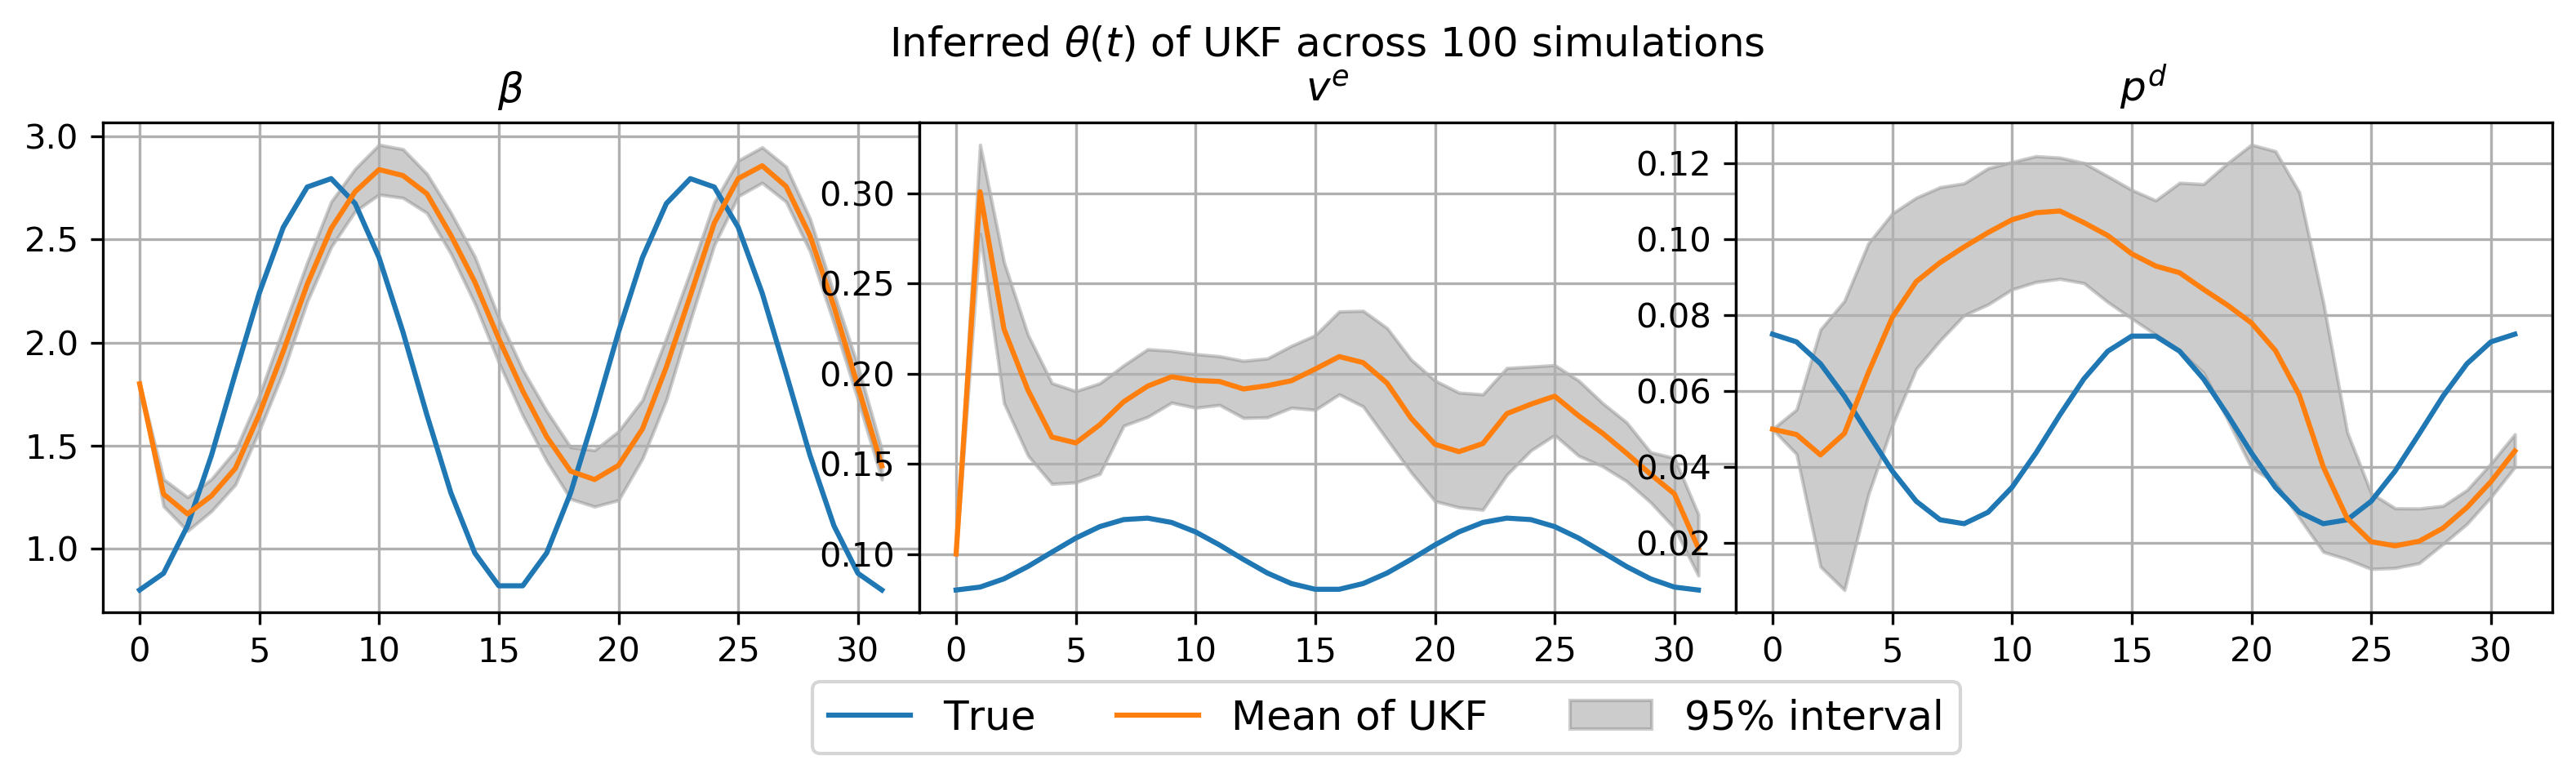

In [3]:
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
x = np.arange(0, 32, 1 / discretization)

ax1 = plt.subplot(1, 3, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_beta, 97.5, axis=0)
upper_95 = np.percentile(all_beta, 2.5, axis=0)

plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_beta, label='True')
plt.plot(x, np.mean(all_beta, axis=0), label='Mean of UKF')
plt.title(r'$\beta$')
plt.grid()
plt.legend(bbox_to_anchor=(2.3, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 3, 2)
lower_95 = np.percentile(all_ve, 97.5, axis=0)
upper_95 = np.percentile(all_ve, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, true_ve)
plt.plot(x, np.mean(all_ve, axis=0))
plt.grid()
plt.title(r'$v^e$')


ax3 = plt.subplot(1, 3, 3)
lower_95 = np.percentile(all_pd, 97.5, axis=0)
upper_95 = np.percentile(all_pd, 2.5, axis=0)
plt.fill_between(x, lower_95 / 4, upper_95 / 4, color='grey', alpha = 0.4)
plt.plot(x, true_pd)
plt.plot(x, np.mean(all_pd / 4, axis=0))
plt.title(r'$p^d$')
plt.grid()
plt.suptitle(r'Inferred $\theta(t)$ of UKF across 100 simulations', y=1.2)

# Reconstruct data

In [4]:
def recover_data(true_re, true_ve, true_vi, true_pd, days, obs_per_day, state0=[N, 100, 50, 50], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    freq = 1. / discretization
    nFull = days * obs_per_day
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = int(i / linspace)
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi[index]
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi[index] * true_pd[index] / 4
    states = state_ls[::linspace]
    # add noise
    return states



fitted = np.zeros((100, days * discretization, 4))
for i in range(100):
#     print(i)
    fitted[i] = recover_data(all_beta[i], all_ve[i], all_vi[i], all_pd[i], days=32, obs_per_day=1, state0 = [100000, 100, 50, 50])

# True data

In [5]:
def true_data(days=32, obs_per_day=1, state0=[100000., 100., 50., 50.], linspace=1000):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    parameter_value = [1.8, 0.1, 0.1, 0.05]
    std = [1., 0.02, 0, 0.025]
    tmp = np.linspace(0, 2 * T * np.pi, 32000)
    true_re = parameter_value[0] - std[0] * np.cos(tmp)
    true_ve = parameter_value[1]- std[1] * np.cos(tmp)
    true_vi = parameter_value[2] 
    true_pd = parameter_value[3] + std[3] * np.cos(tmp)
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 4))
    state_ls[0][0] = state0[0]
    state_ls[0][1] = state0[1]
    state_ls[0][2] = state0[2]
    state_ls[0][3] = state0[3]

    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] - step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N
        state_ls[i][1] = state_ls[i - 1][1] + step_size * true_re[index] * state_ls[i - 1][2] * state_ls[i - 1][0] / N - step_size * true_ve[index] * state_ls[i - 1][1]
        state_ls[i][2] = state_ls[i - 1][2] + step_size * true_ve[index] * state_ls[i - 1][1] - step_size * state_ls[i - 1][2] * true_vi
        state_ls[i][3] = state_ls[i - 1][3] + step_size * state_ls[i - 1][2] * true_vi * true_pd[index]
    states = state_ls[::linspace]
    return states

true_x = true_data()

Text(0.5, 1.2, 'Reconstructed $x(t)$ of UKF across 100 simulations')

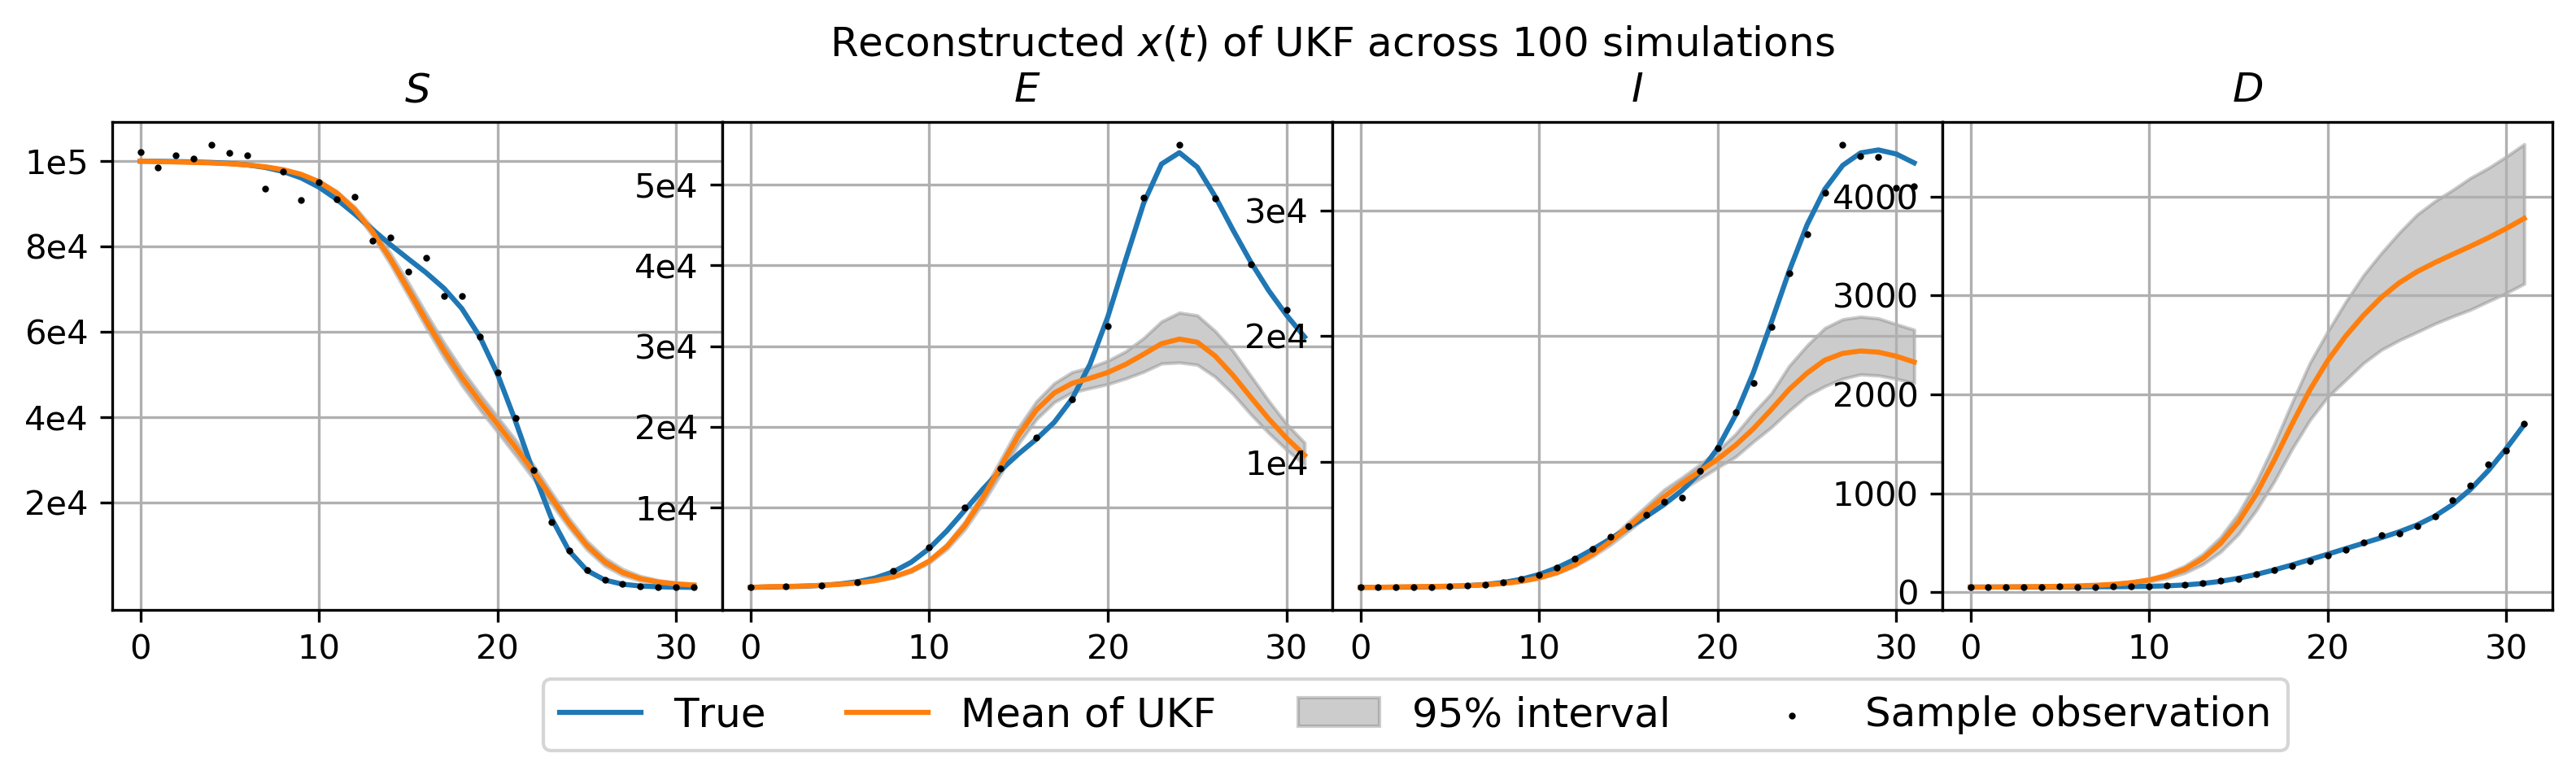

In [7]:
yobs = np.exp(np.load('SEIRD observations.npy')[1])
figsize(10, 2)
plt.subplots_adjust(top=1,bottom=0,left=0,right=1, wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(fitted[:,:, 0], 95, axis=0)
upper_95 = np.percentile(fitted[:,:, 0], 5, axis=0)
plt.yticks(np.array([20000, 40000, 60000, 80000, 100000]), ['2e4', '4e4', '6e4', '8e4', '1e5'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(true_x[:, 0], label='True')
plt.plot(x, np.mean(fitted[:,:, 0], axis=0), label='Mean of UKF')
plt.scatter(np.arange(0, 32, 1), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$S$')
plt.legend(bbox_to_anchor=(3.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(fitted[:,:, 1], 95, axis=0)
upper_95 = np.percentile(fitted[:,:, 1], 5, axis=0)
plt.yticks(np.array([10000, 20000, 30000, 40000, 50000]), ['1e4', '2e4', '3e4', '4e4', '5e4'])
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 1])
plt.plot(x, np.mean(fitted[:,:, 1], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$E$')


ax3 = plt.subplot(1, 4, 3)
lower_95 = np.percentile(fitted[:,:, 2], 95, axis=0)
upper_95 = np.percentile(fitted[:,:, 2], 5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.yticks(np.array([10000, 20000, 30000]), ['1e4', '2e4', '3e4'])
plt.plot(true_x[:, 2])
plt.plot(x, np.mean(fitted[:,:, 2], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 2], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$I$')


ax4= plt.subplot(1, 4, 4)
lower_95 = np.percentile(fitted[:,:, 3], 95, axis=0)
upper_95 = np.percentile(fitted[:,:, 3], 5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(true_x[:, 3])
plt.plot(x, np.mean(fitted[:,:, 3], axis=0))
plt.scatter(np.arange(0, 32, 1), yobs[:, 3], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title(r'$D$')
plt.suptitle(r'Reconstructed $x(t)$ of UKF across 100 simulations', y=1.2)

In [7]:
RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(fitted[i, ::2, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(fitted[i, ::2, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(fitted[i, ::2, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(fitted[i, ::2, 3] - true_x[:, 3])))
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))

10142.598523296272 702.6988296161352
11539.24483473993 769.5830888295986
5995.9850279539205 792.6761208873656
1286.076203939284 177.33594384235823


In [25]:
RMSE_S = np.zeros(100)
RMSE_E = np.zeros(100)
RMSE_I = np.zeros(100)
RMSE_D = np.zeros(100)

for i in range(100):
    RMSE_S[i] = np.sqrt(np.mean(np.square(fitted[i, :, 0] - true_x[:, 0])))
    RMSE_E[i] = np.sqrt(np.mean(np.square(fitted[i, :, 1] - true_x[:, 1])))
    RMSE_I[i] = np.sqrt(np.mean(np.square(fitted[i, :, 2] - true_x[:, 2])))
    RMSE_D[i] = np.sqrt(np.mean(np.square(fitted[i, :, 3] - true_x[:, 3])))
print(np.mean(RMSE_S), np.std(RMSE_S))
print(np.mean(RMSE_E), np.std(RMSE_E))
print(np.mean(RMSE_I), np.std(RMSE_I))
print(np.mean(RMSE_D), np.std(RMSE_D))

6158.663003849408 392.703555873446
10928.634743127497 835.5378063288912
7344.139343291337 681.7360571729705
1521.5322076291172 216.32548679413026


In [8]:
RMSE_beta = np.zeros(100)
RMSE_ve = np.zeros(100)
RMSE_vi = np.zeros(100)
RMSE_pd = np.zeros(100)

for i in range(100):
    RMSE_beta[i] = np.sqrt(np.mean(np.square(all_beta[i] - true_beta)))
    RMSE_ve[i] = np.sqrt(np.mean(np.square(all_ve[i] - true_ve)))
    RMSE_vi[i] = np.sqrt(np.mean(np.square(all_vi[i] - true_vi)))
    RMSE_pd[i] = np.sqrt(np.mean(np.square(all_pd[i]/4 - true_pd)))
    
print(np.mean(RMSE_beta), np.std(RMSE_beta))
print(np.mean(RMSE_ve), np.std(RMSE_ve))
print(np.mean(RMSE_vi), np.std(RMSE_vi))
print(np.mean(RMSE_pd), np.std(RMSE_pd))

0.7608063157512355 0.016149201099071798
0.14690524652400083 0.005792545487864238
0.3298610260143814 0.021619818782578997
0.025705759473972183 0.004265260831452268


In [17]:
ukf_ls.shape

(100, 32, 16)

In [18]:
discretization

1